In [1]:
import numpy as np
from tqdm import tqdm


In [2]:
def read_data(file_path):
    text = open(file_path, 'r').read()
    text = text.strip()
    text = text.replace(' ', '#')
    return text

text = read_data('textA.txt')


In [3]:
class simpleHMM:
    def __init__(self, states=2, observations=27, initial_transitions=None, initial_emissions=None):
        self.transitions = np.ones((states, states)) / states
        self.emissions = np.ones((states, observations)) / observations

        if initial_transitions is not None:
            self.transitions = initial_transitions
        if initial_emissions is not None:
            self.emissions = initial_emissions

        self.states = states
        self.observations = observations

    def forward(self, sequence):
        alpha_normalized = np.zeros((len(sequence) + 1, self.states))
        q_values = np.zeros(len(sequence) + 1)

        alpha_normalized[0] = np.ones(self.states) / self.states
        q_values[0] = 1

        for t in range(1, len(sequence) + 1):
            alpha_normalized[t] = alpha_normalized[t - 1] @ self.transitions *  self.emissions[:, self.get_character_index(sequence[t - 1])]
            q_values[t] = np.sum(alpha_normalized[t])
            alpha_normalized[t] = alpha_normalized[t] / np.sum(alpha_normalized[t])
        
        self.alpha_normalized = alpha_normalized
        self.q_values = q_values
        return alpha_normalized, q_values

    def backward(self, sequence):
        beta_normalized = np.zeros((len(sequence) + 1, self.states))
        beta_normalized[-1] = np.ones(self.states) / self.states

        for t in range(len(sequence) - 1, -1, -1):
            beta_normalized[t] = self.transitions * self.emissions[:, self.get_character_index(sequence[t])] @ beta_normalized[t + 1]
            beta_normalized[t] = beta_normalized[t] / self.q_values[t]

        self.beta_normalized = beta_normalized
        return beta_normalized

    def BW(self, sequence):
        self.forward(sequence)
        self.backward(sequence)
        transitions_posterior_probs = np.zeros((len(sequence), self.states, self.states))
        new_emission_probs = np.zeros((self.states, self.observations))


        for i in range(len(sequence)):
            for l in range(self.states):
                for r in range(self.states):
                    posterior_prob = self.alpha_normalized[i,l] * self.transitions[l,r] * self.emissions[r, self.get_character_index(sequence[i])] * self.beta_normalized[i+1,r]
                    new_emission_probs[r, self.get_character_index(sequence[i])] += posterior_prob
                    transitions_posterior_probs[i,l,r] = posterior_prob

        new_transition_prob = np.sum(transitions_posterior_probs, axis=0)
        new_transition_prob = new_transition_prob / np.sum(new_transition_prob, axis=1, keepdims=True)

        new_emission_prob = new_emission_probs / np.sum(new_emission_probs, axis=1, keepdims=True)

        #self.transitions = new_transition_prob
        #self.emissions = new_emission_prob

        return new_transition_prob, new_emission_prob

    def BW_loop(self, sequence):
        epsilon = 1e-10
        diff = 10000

        itercount = 0
        while diff > epsilon:
            new_transition_prob, new_emission_prob = self.BW(sequence)
            diff = np.sum(np.abs(self.transitions - new_transition_prob)) + np.sum(np.abs(self.emissions - new_emission_prob))
            self.transitions = new_transition_prob
            self.emissions = new_emission_prob
            itercount += 1

        print(f"Converged in {itercount} iterations")



    def BW_loop_for_part_b(self, sequence_a, sequence_b, max_iter=600):
        """
        modification of the BW loop to get answer for part b
        """
        a_logprob = []
        b_logprob = []
        for i in tqdm(range(max_iter)):
            
            # This is inefficient but saves me time to refactor :)
            a_logprob.append(self.get_sequence_prob(sequence_a))
            b_logprob.append(self.get_sequence_prob(sequence_b))
            
            new_transition_prob, new_emission_prob = self.BW(sequence_a)
            self.transitions = new_transition_prob
            self.emissions = new_emission_prob
            # if i % 20 == 0:
            #     print(f"Iteration {i}:")
            #     print("a_logrpob: " + str(a_logprob[-1]))
            #     print("b_logrpob: " + str(b_logprob[-1])) 
            
        

        return a_logprob, b_logprob


    def BW_loop_for_part_c(self, sequence_a, max_iter=600):
        a_1 = []
        a_2 = []
        n_1 = []
        n_2 = []
        for i in tqdm(range(max_iter)):
            a_1.append(self.emissions[0, self.get_character_index('a')])
            a_2.append(self.emissions[1, self.get_character_index('a')])
            n_1.append(self.emissions[0, self.get_character_index('n')])
            n_2.append(self.emissions[1, self.get_character_index('n')])
            new_transition_prob, new_emission_prob = self.BW(sequence_a)
            self.transitions = new_transition_prob
            self.emissions = new_emission_prob
        return a_1, a_2, n_1, n_2
    
    def BW_loop_for_part_2c(self, sequence_a, sequence_b, max_iter=600):
        a1 = []
        a2 = []
        a3 = []
        a4 = []
        n1 = []
        n2 = []
        n3 = []
        n4 = []
        for i in tqdm(range(max_iter)):
            a1.append(self.emissions[0, self.get_character_index('a')])
            a2.append(self.emissions[1, self.get_character_index('a')])
            a3.append(self.emissions[2, self.get_character_index('a')])
            a4.append(self.emissions[3, self.get_character_index('a')])
            n1.append(self.emissions[0, self.get_character_index('n')])
            n2.append(self.emissions[1, self.get_character_index('n')])
            n3.append(self.emissions[2, self.get_character_index('n')])
            n4.append(self.emissions[3, self.get_character_index('n')])
            new_transition_prob, new_emission_prob = self.BW(sequence_a)
            self.transitions = new_transition_prob
            self.emissions = new_emission_prob
        return a1, a2, a3, a4, n1, n2, n3, n4

    def get_sequence_prob(self, sequence):
        a_n, q = self.forward(sequence)
        #currently using base e log
        return np.sum(np.log(q[1:])) / len(sequence)
        
        


    def get_character_index(self, character):
        index = ord(character) - ord('a')
        if index < 0 or index >= self.observations: # the observation is space, denoted '#'
            index = 26
        return index


In [4]:
counts = {}
for c in text:
    counts[c] = counts.get(c, 0) + 1

# order by key
counts = dict(sorted(counts.items()))
for k, v in counts.items():
    v = v / len(text)
    print(k, v)


# 0.1688
a 0.06773333333333334
b 0.012433333333333333
c 0.028666666666666667
d 0.03593333333333333
e 0.105
f 0.0182
g 0.0146
h 0.037233333333333334
i 0.0579
j 0.0027333333333333333
k 0.0045
l 0.0391
m 0.0192
n 0.05413333333333333
o 0.06503333333333333
p 0.0193
q 0.0008333333333333334
r 0.05333333333333334
s 0.05616666666666666
t 0.0779
u 0.022733333333333335
v 0.008066666666666666
w 0.013233333333333333
x 0.0028
y 0.013966666666666667
z 0.00046666666666666666


### Part 1.b

In [5]:
# even though this is part b, this is an initialization from part a
part_a_transition = np.array([[.49, .51],[.51, .49]])
part_a_emission = np.ones((2, 27)) / 27
part_a_emission[0,:13] = .0370
part_a_emission[1,13:] = .0370
part_a_emission[0,13:] = .0371
part_a_emission[1,:13] = .0371
part_a_emission[:,26] = .0367


In [6]:
text_a = read_data('textA.txt')
text_b = read_data('textB.txt')


In [7]:
hmm = simpleHMM(initial_transitions=part_a_transition, initial_emissions=part_a_emission)
a_logprob, b_logprob = hmm.BW_loop_for_part_b(text_a, text_b)


100%|██████████| 600/600 [03:50<00:00,  2.60it/s]


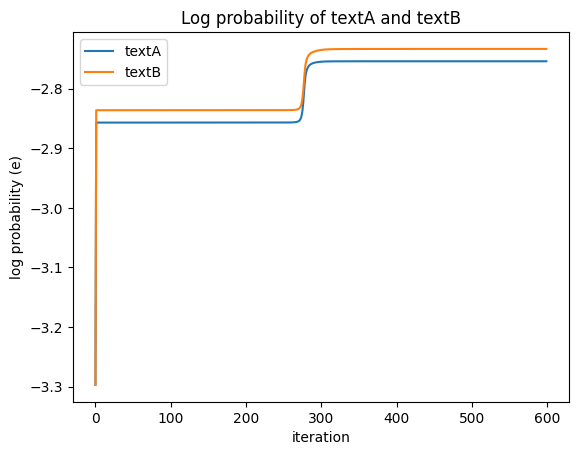

In [8]:
import matplotlib.pyplot as plt

plt.plot(a_logprob, label='textA')
plt.plot(b_logprob, label='textB')
plt.xlabel('iteration')
plt.ylabel('log probability (e)')
plt.legend()
plt.title("Log probability of textA and textB")
plt.savefig('part1_b.png')
plt.show()




### Part 1.c

In [9]:
hmm = simpleHMM(initial_transitions=part_a_transition, initial_emissions=part_a_emission)
a_1, a_2, n_1, n_2 = hmm.BW_loop_for_part_c(text_a)

100%|██████████| 600/600 [02:32<00:00,  3.94it/s]


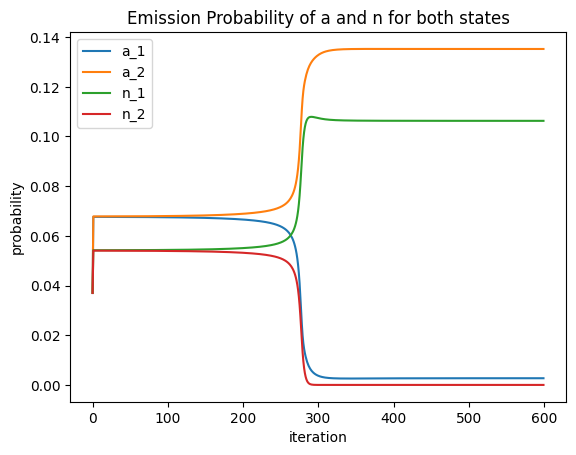

In [10]:
plt.plot(a_1, label='a_1')
plt.plot(a_2, label='a_2')
plt.plot(n_1, label='n_1')
plt.plot(n_2, label='n_2')
plt.xlabel('iteration')
plt.ylabel('probability')
plt.legend()
plt.title("Emission Probability of a and n for both states")
plt.savefig('part1_c.png')
plt.show()



### Part 1.d

In [11]:
# assumes that you already rean from part 1.c
emission_matrix = hmm.emissions
emission_matrix_diff = emission_matrix[1] - emission_matrix[0]
print(emission_matrix_diff)


[ 0.13253571 -0.02441499 -0.05606673 -0.07056129  0.21395822 -0.03573883
 -0.02866961 -0.07079246  0.11798267 -0.00536737 -0.00733841 -0.07677956
 -0.03770251 -0.10630012  0.13251825 -0.03789887 -0.00163639 -0.10472918
 -0.11029292 -0.13731797  0.04632365 -0.01584029 -0.02598593 -0.00549828
 -0.02742595 -0.00091638  0.34395553]


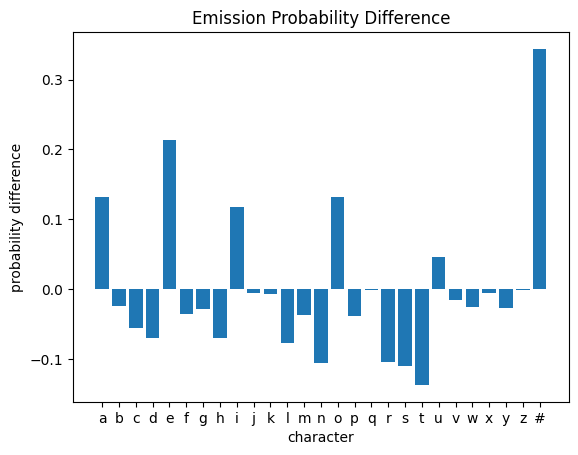

In [12]:
x_axis = [chr(i) for i in range(ord('a'), ord('z') + 1)]
x_axis.append('#')
plt.bar(x_axis, emission_matrix_diff)
plt.xlabel('character')
plt.ylabel('probability difference')
plt.title('Emission Probability Difference')
plt.savefig('part1_d.png')
plt.show()



# the vowels and space have high probability in the second state



## Part 2

### Part 2.a

In [13]:
simple_hmm = simpleHMM(states=4)
simple_hmm.BW(text_a)

### Again, the model is only able to learn unigram distribution


(array([[0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25]]),
 array([[0.06773333, 0.01243333, 0.02866667, 0.03593333, 0.105     ,
         0.0182    , 0.0146    , 0.03723333, 0.0579    , 0.00273333,
         0.0045    , 0.0391    , 0.0192    , 0.05413333, 0.06503333,
         0.0193    , 0.00083333, 0.05333333, 0.05616667, 0.0779    ,
         0.02273333, 0.00806667, 0.01323333, 0.0028    , 0.01396667,
         0.00046667, 0.1688    ],
        [0.06773333, 0.01243333, 0.02866667, 0.03593333, 0.105     ,
         0.0182    , 0.0146    , 0.03723333, 0.0579    , 0.00273333,
         0.0045    , 0.0391    , 0.0192    , 0.05413333, 0.06503333,
         0.0193    , 0.00083333, 0.05333333, 0.05616667, 0.0779    ,
         0.02273333, 0.00806667, 0.01323333, 0.0028    , 0.01396667,
         0.00046667, 0.1688    ],
        [0.06773333, 0.01243333, 0.02866667, 0.03593333, 0.105     ,
         0.0182    , 0.0146    , 0.

### Part 2.b

In [14]:
def get_initial_transition_emission_matrix_for_b():
    transition_initialization_b = np.array([
    [.23, .24, .25, .28],
    [.28, .23, .24, .25],
   [.25, .28, .23, .24],
   [.24, .25, .28, .23] 
    ])
    probs = [.03715, .0371, .037, .03695]
    probs_remainder = ((1 - sum(probs) * 6) / 3)
    emission_initialization_b = np.ones((4, 27)) / 27
    
    for i in range(4):
        for j in range(4):
            start_index = (6 * (i + j) ) % 24
            end_index = (6 * (i + j + 1)) % 24
            if end_index == 0:
                end_index = 24
            emission_initialization_b[i, start_index:end_index] = probs[j]
        emission_initialization_b[i, 24:] = probs_remainder
        
    return transition_initialization_b, emission_initialization_b


transition_initialization_b, emission_initialization_b = get_initial_transition_emission_matrix_for_b()

In [15]:
hmm_2 = simpleHMM(states=4, initial_transitions=transition_initialization_b, initial_emissions=emission_initialization_b)

In [16]:
a_logprob_2, b_logprob_2 = hmm_2.BW_loop_for_part_b(text_a, text_b, max_iter=600)

100%|██████████| 600/600 [06:07<00:00,  1.63it/s]


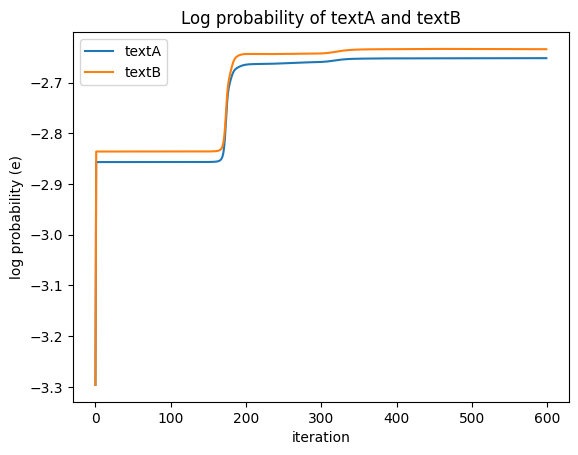

In [17]:
import matplotlib.pyplot as plt

plt.plot(a_logprob_2, label='textA')
plt.plot(b_logprob_2, label='textB')
plt.xlabel('iteration')
plt.ylabel('log probability (e)')
plt.legend()
plt.title("Log probability of textA and textB")
plt.savefig('part2_b.png')
plt.show()




### Part 2.c

100%|██████████| 600/600 [04:36<00:00,  2.17it/s]


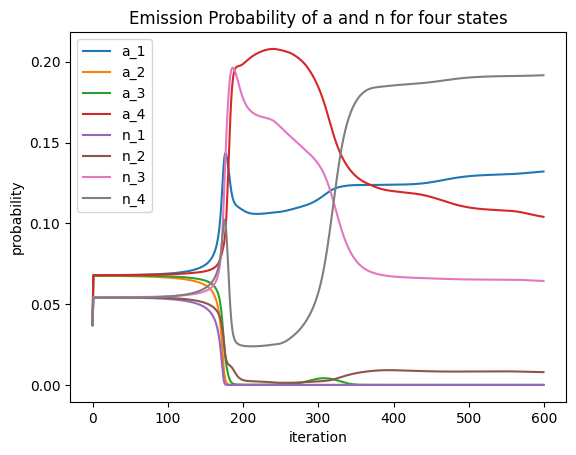

In [18]:
hmm_2 = simpleHMM(states=4, initial_transitions=transition_initialization_b, initial_emissions=emission_initialization_b)
a1, a2, a3, a4, n1, n2, n3, n4 = hmm_2.BW_loop_for_part_2c(text_a, text_b, max_iter=600)
plt.plot(a1, label='a_1')
plt.plot(a2, label='a_2')
plt.plot(a3, label='a_3')
plt.plot(a4, label='a_4')
plt.plot(n1, label='n_1')
plt.plot(n2, label='n_2')
plt.plot(n3, label='n_3')
plt.plot(n4, label='n_4')
plt.xlabel('iteration')
plt.ylabel('probability')
plt.legend()
plt.title("Emission Probability of a and n for four states")
plt.savefig('part2_c.png')
plt.show()

### Part 2.d

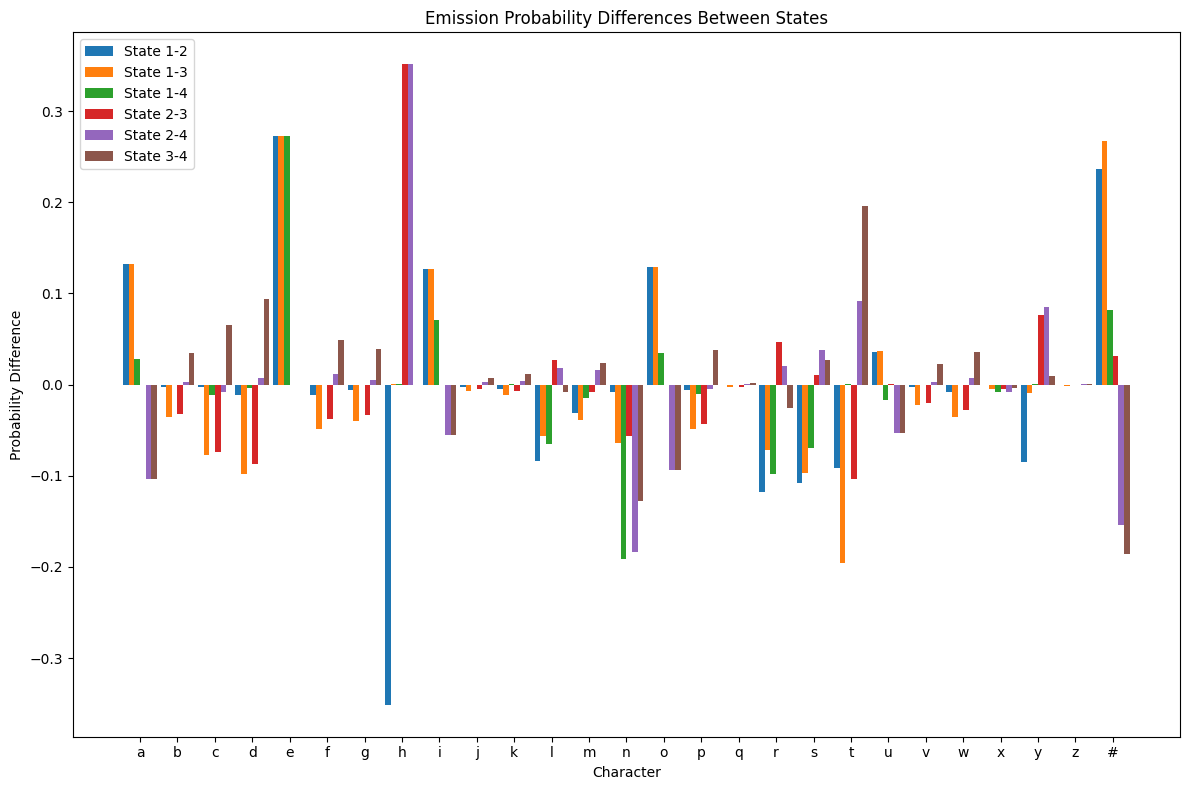

In [19]:
s_1 = hmm_2.emissions[0]
s_2 = hmm_2.emissions[1]
s_3 = hmm_2.emissions[2]
s_4 = hmm_2.emissions[3]

s_12 = s_1 - s_2
s_13 = s_1 - s_3
s_14 = s_1 - s_4
s_23 = s_2 - s_3
s_24 = s_2 - s_4
s_34 = s_3 - s_4

x_axis = [chr(i) for i in range(ord('a'), ord('z') + 1)]
x_axis.append('#')
fig, ax = plt.subplots(figsize=(12, 8))

width = 0.15  # width of the bars
x = np.arange(len(x_axis))  # the label locations

rects1 = ax.bar(x - 2.5*width, s_12, width, label='State 1-2')
rects2 = ax.bar(x - 1.5*width, s_13, width, label='State 1-3')
rects3 = ax.bar(x - 0.5*width, s_14, width, label='State 1-4')
rects4 = ax.bar(x + 0.5*width, s_23, width, label='State 2-3')
rects5 = ax.bar(x + 1.5*width, s_24, width, label='State 2-4')
rects6 = ax.bar(x + 2.5*width, s_34, width, label='State 3-4')

ax.set_xlabel('Character')
ax.set_ylabel('Probability Difference')
ax.set_title('Emission Probability Differences Between States')
ax.set_xticks(x)
ax.set_xticklabels(x_axis)
ax.legend()

plt.tight_layout()
plt.savefig('part2_d.png')
plt.show()



## Part 3

In [20]:
# Copy from part 1
def read_data(file_path):
    text = open(file_path, 'r').read()
    text = text.strip()
    text = text.replace(' ', '#')
    return text



def get_unigram_distribution(text):
    counts = [0] * 27
    for c in text:
        if c == "#":
            counts[26] += 1
        else:
            counts[ord(c) - ord('a')] += 1
    return np.array(counts) / len(text)

text_a = read_data('textA.txt')
text_b = read_data('textB.txt')
unigram_distribution = get_unigram_distribution(text_a)
print(unigram_distribution)







[0.06773333 0.01243333 0.02866667 0.03593333 0.105      0.0182
 0.0146     0.03723333 0.0579     0.00273333 0.0045     0.0391
 0.0192     0.05413333 0.06503333 0.0193     0.00083333 0.05333333
 0.05616667 0.0779     0.02273333 0.00806667 0.01323333 0.0028
 0.01396667 0.00046667 0.1688    ]


In [21]:
import random
def get_delta_distribution(length):
    r =[random.random() for _ in range(length)]
    r_avg = sum(r) / length
    delta = [r[i] - r_avg for i in range(length)]
    return np.array(delta)

delta_value = get_delta_distribution(27)


In [22]:
def get_estimated_emssion_and_lambda(unigram_distribution, delta_value):
    """
    Derives the bona fide probability assignment of Y, according to description of 3
    lambda value is decreased 10 times until all the values are positive
    input:
        unigram_distribution: the unigram distribution of the text
        delta_value: the delta value of the text
    output:
        estimated_emission: the estimated emission matrix
        lambda: lambda value used.
    """
    starting_lambda = .1
    while True:
        state_1_emission = unigram_distribution - starting_lambda * delta_value
        state_2_emission = unigram_distribution + starting_lambda * delta_value

        if np.all(state_1_emission > 0) and np.all(state_2_emission > 0):
            break
        starting_lambda *= .1
    estimated_emission = np.array([state_1_emission, state_2_emission])
    return estimated_emission, starting_lambda

estimated_emission, starting_lambda = get_estimated_emssion_and_lambda(unigram_distribution, delta_value)
print(estimated_emission.shape)
print(starting_lambda)




(2, 27)
0.0010000000000000002


In [23]:
part_c_transition = np.array([[.49, .51],[.51, .49]])
part_c_emission = estimated_emission
hmm = simpleHMM(initial_transitions=part_c_transition, initial_emissions=part_c_emission)
a_logprob, b_logprob = hmm.BW_loop_for_part_b(text_a, text_b)




100%|██████████| 600/600 [03:56<00:00,  2.54it/s]


In [24]:
# copy from part 1.b
part_a_transition = np.array([[.49, .51],[.51, .49]])
part_a_emission = np.ones((2, 27)) / 27
part_a_emission[0,:13] = .0370
part_a_emission[1,13:] = .0370
part_a_emission[0,13:] = .0371
part_a_emission[1,:13] = .0371
part_a_emission[:,26] = .0367
hmm_a = simpleHMM(initial_transitions=part_a_transition, initial_emissions=part_a_emission)
a_logprob_a, b_logprob_a = hmm_a.BW_loop_for_part_b(text_a, text_b)


100%|██████████| 600/600 [03:55<00:00,  2.55it/s]


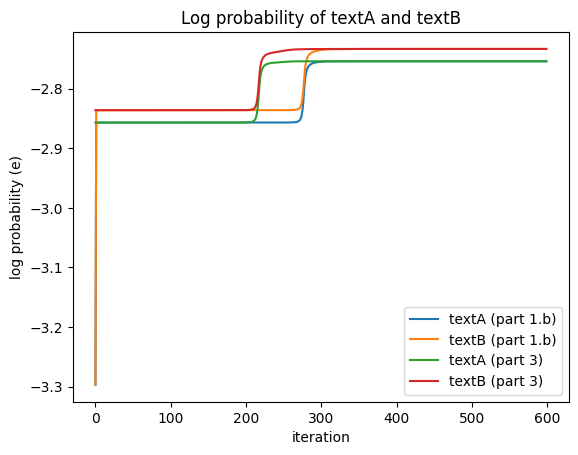

In [27]:
plt.plot(a_logprob_a, label='textA (part 1.b)')
plt.plot(b_logprob_a, label='textB (part 1.b)')
plt.plot(a_logprob, label='textA (part 3)')
plt.plot(b_logprob, label='textB (part 3)')

plt.xlabel('iteration')
plt.ylabel('log probability (e)')
plt.legend()
plt.title("Log probability of textA and textB")
plt.savefig('part3.png')
plt.show()



In [26]:
print("alternative logprob textA: ", a_logprob[-1])
print("alternative logprob textB: ", b_logprob[-1])
print("part 1.b logprob textA: ", a_logprob_a[-1])
print("part 1.b logprob textB: ", b_logprob_a[-1])




alternative logprob textA:  -2.75387238936428
alternative logprob textB:  -2.733149688473811
part 1.b logprob textA:  -2.7538724362001243
part 1.b logprob textB:  -2.7331446052299952
